In [1]:

import bokeh
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os

import pickle
import torch
import torch.nn as nn
from torch import optim
from torchvision.models import ResNet152_Weights, resnet152
import tqdm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from transformers import AutoModel, AutoTokenizer

from torchvision.transforms import functional
from torchvision.transforms import ToTensor, Normalize, Compose

import io

from PIL import Image

import umap
import umap.plot
from sklearn.neighbors import NearestNeighbors

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


/ghome/group01/anaconda3/envs/gpu_torch_new/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_image(image_id, root_path):
        if isinstance(image_id, int):
            image_path = os.path.join(
                root_path, f"COCO_train2014_{str(image_id).zfill(12)}.jpg"
            )
        else:
            image_path = f"/export/home/group01/MCV-C5-G1/Week5/generated_images/{image_id}"

        image = Image.open(image_path).convert("RGB")
        return image
    
@torch.no_grad
def extract_embedding_resnet(id, root_path):
    model = resnet152(weights=ResNet152_Weights.DEFAULT)
    modules=list(model.children())[:-1]
    model=nn.Sequential(*modules).to(DEVICE)
    model.eval()
    
    image = load_image(id, root_path=root_path)
    image = functional.normalize(functional.to_tensor(image), mean=(0.485, 0.456, 0.406),
                                            std=(0.229, 0.224, 0.225)).to(DEVICE)
    
    image = functional.resize(img=image, size=(224,224))
    features = model(image.unsqueeze(0)).view(-1, 2048) 
    return features.cpu().numpy()


def embeddings_bert(model_txt, tokenizer, captions):
    embedded_captions = {}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_txt.to(device)
    for caption in tqdm.tqdm(captions):
        inputs = tokenizer(
            caption,
            return_tensors="pt",
            padding="longest",
            add_special_tokens=True,
            return_attention_mask=True,
        ).to(device)
        embedded_caption = model_txt(**inputs).last_hidden_state[:, 0, :]
        embedded_captions.update({caption: embedded_caption.squeeze()})
    return embedded_captions


def generate_embeddings(triplets):
    captions = [triplet[0] for triplet in triplets]
    model_txt = AutoModel.from_pretrained("bert-base-uncased")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model_txt.eval()
    for param in model_txt.parameters():
        param.requires_grad = False

    embeddings = embeddings_bert(model_txt, tokenizer, captions=captions)

    return embeddings



def save_pickle(embeddings, rooth_path, name):
    with open(rooth_path + name , "wb") as file:
        pickle.dump(embeddings, file)  
        
        
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
    distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
    return np.mean(distances)

In [3]:


TRAIN_PATH = "/ghome/group01/mcv/datasets/C5/COCO/train2014"
VAL_PATH = "/ghome/group01/mcv/datasets/C5/COCO/val2014"

TRIPLET_PICKLES = "pickles/triplets/triplets.pkl"
EXTENDED_PICKLES = "pickles/triplets/triplets_final.pkl"

EXPORTED_PICKLES = "pickles/db_features/"
EXPORTED_PICKLES_DATA_ANALYSIS = "pickles/data_analysis/"

TRAIN_RESNET_PKL = "training_resnet_embeddings.pkl"
TRAIN_BERT_PKL = "training_bert_embeddings.pkl"



In [4]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)



In [5]:

with open(TRIPLET_PICKLES, "rb") as f:
    triplets = pickle.load(f)
    
with open(EXPORTED_PICKLES + TRAIN_RESNET_PKL, "rb") as file:
    embeddings_train_resnet = pickle.load(file)


with open(EXPORTED_PICKLES + TRAIN_BERT_PKL, "rb") as file:
    contents = CPU_Unpickler(file).load()
    #embeddings_train_bert = pickle.load(file)

## Visualize Distributions Bert

In [6]:
bert_embeddings = np.array(list(contents.values()))

if os.path.exists(EXPORTED_PICKLES_DATA_ANALYSIS + "umap_bert_pretrain.pkl"):
    with open(EXPORTED_PICKLES_DATA_ANALYSIS + "umap_bert_pretrain.pkl", "rb") as f:
        mapper_bert = pickle.load(f)
else:
    mapper_bert = umap.UMAP().fit(bert_embeddings)


<Axes: >

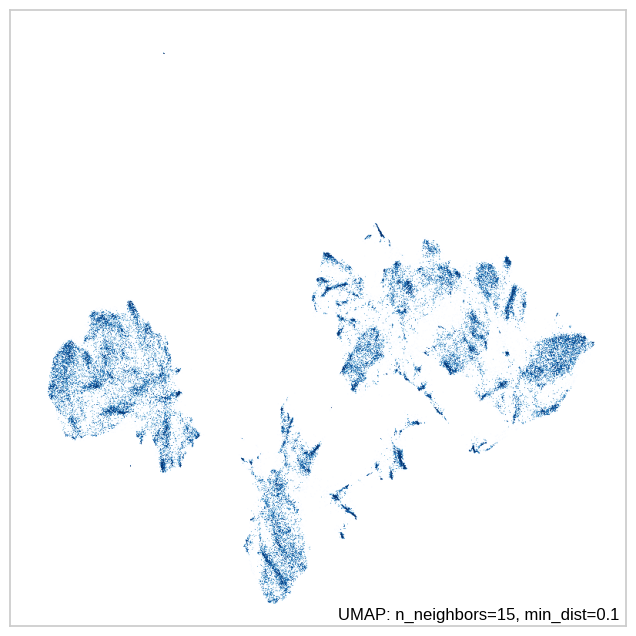

In [7]:
umap.plot.points(mapper_bert)

In [8]:
if os.path.exists(EXPORTED_PICKLES_DATA_ANALYSIS + "kmeans_bert_pretrain.pkl"):
    with open(EXPORTED_PICKLES_DATA_ANALYSIS + "kmeans_bert_pretrain.pkl", "rb") as f:
        km_bert = pickle.load(f)
else:
    km_bert = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42)
    new_embeddings = km_bert.fit(bert_embeddings)

labels_bert = km_bert.predict(bert_embeddings)

<Axes: >

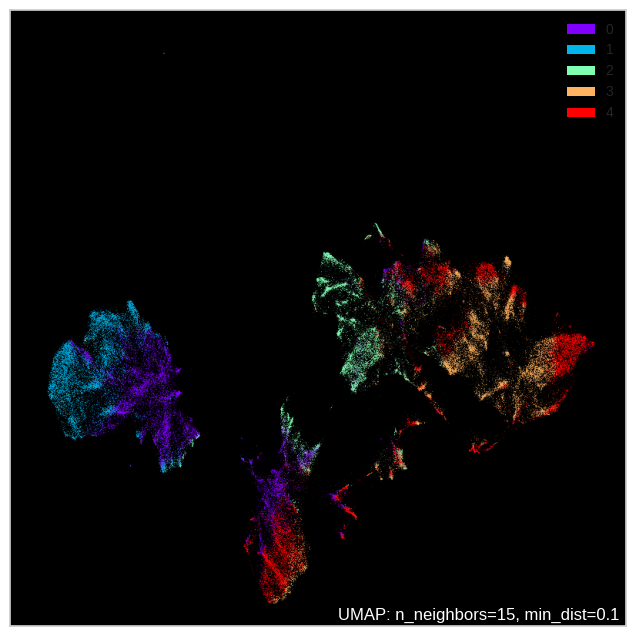

In [9]:
umap.plot.points(mapper_bert, labels=labels_bert, theme='fire')

In [45]:
#save_pickle(km_bert, rooth_path=EXPORTED_PICKLES_DATA_ANALYSIS, name="kmeans_bert_pretrain.pkl")
#save_pickle(mapper_bert, rooth_path=EXPORTED_PICKLES_DATA_ANALYSIS, name="umap_bert_pretrain.pkl")

In [10]:
class_caption = {i: [] for i in range(len(km_bert.cluster_centers_))}
for lab, (captions, embedding)  in zip(labels_bert, contents.items()):
    class_caption[lab].append(captions) 

In [11]:
class_caption[3]

['A white double decker bus driving down a street.',
 'Large buildings and people walking on the sidewalk.',
 'A woman riding skis down a snow covered slope.',
 'Black and white image of someone flying a kite',
 'A group of young men trying to catch a frisbee.',
 'A photo of an elephant statue in a park under a tree.',
 'A man flying through the air while riding a snow board.',
 'A couple of bears playing in a pool at a zoo.',
 'Some very cute looking ducks in  the grass.',
 'A man riding a wave on top of a surfboard.',
 'A woman petting a sheep inside a pen at a fair. ',
 'A person on a surfboard riding the crest of a wave.',
 'A horse standing on top of a wave covered beach.',
 'Single giraffe standing in grass eating leaves from trees.',
 'A man sitting and eating a slice of pizza.',
 'Group of giraffes walking through a small wooded area. ',
 'A large cow on a sandy beach by the water.',
 'People flying kites on a grassy hill under a clear blue sky.',
 'Person being pulled over wat

# Visualize Dsitributions Resnet

In [12]:
resnet_embeddings = None
for batch in embeddings_train_resnet:
    if resnet_embeddings is None:
        resnet_embeddings = batch
    
    else:
       resnet_embeddings =  np.concatenate((resnet_embeddings, batch), axis=0)

In [13]:
print(resnet_embeddings.shape)

(99900, 2048)


In [14]:
if os.path.exists(EXPORTED_PICKLES_DATA_ANALYSIS + "umap_resnet_pretrain.pkl"):
    with open(EXPORTED_PICKLES_DATA_ANALYSIS + "umap_resnet_pretrain.pkl", "rb") as f:
        mapper_resnet = pickle.load(f)
else:
    mapper_resnet = umap.UMAP().fit(resnet_embeddings)


In [46]:
#save_pickle(mapper_resnet, rooth_path=EXPORTED_PICKLES_DATA_ANALYSIS, name="umap_resnet_pretrain.pkl")

<Axes: >

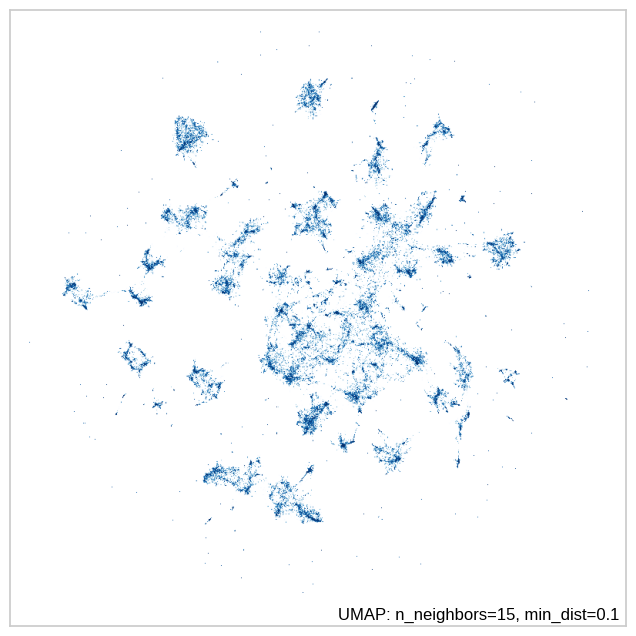

In [15]:
umap.plot.points(mapper_resnet)

## Compute the Distorsion and the inertia because we sample data

In [16]:
from sklearn import metrics
from scipy.spatial.distance import cdist

In [53]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(10, 20)
 
for k in tqdm.tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(resnet_embeddings)
    kmeanModel.fit(resnet_embeddings)
 
    distortions.append(sum(np.min(cdist(resnet_embeddings, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / resnet_embeddings.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(resnet_embeddings, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / resnet_embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████| 10/10 [04:22<00:00, 26.21s/it]


In [56]:

for key, val in mapping1.items():
    print(f'{key} : {val}')

10 : 13.470127472855799
11 : 13.399760892833063
12 : 13.29803250583014
13 : 13.302518519201012
14 : 13.261728592931744
15 : 13.149174301280265
16 : 13.146378438650004
17 : 13.084063915523478
18 : 13.056138855888682
19 : 13.02519880585861


In [57]:

for key, val in mapping2.items():
    print(f'{key} : {val}')

10 : 19686404.0
11 : 19513126.0
12 : 19357072.0
13 : 19254890.0
14 : 19215620.0
15 : 19039990.0
16 : 18980164.0
17 : 18755544.0
18 : 18739226.0
19 : 18636384.0


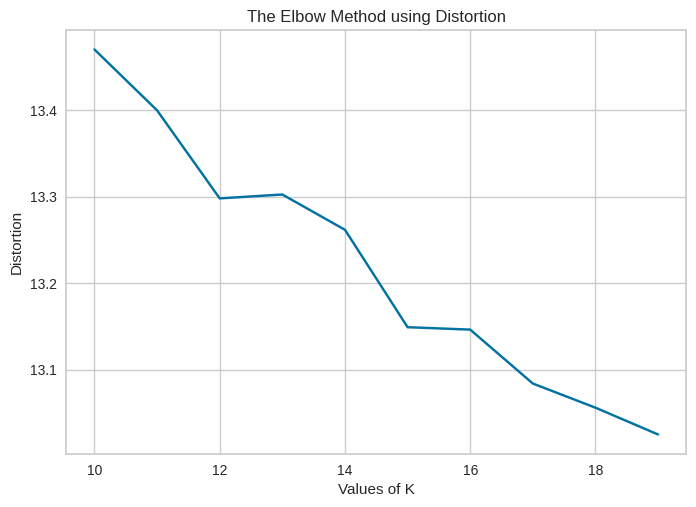

In [59]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [17]:
if os.path.exists(EXPORTED_PICKLES_DATA_ANALYSIS + "kmeans_resnet_pretrain.pkl"):
    with open(EXPORTED_PICKLES_DATA_ANALYSIS + "kmeans_resnet_pretrain.pkl", "rb") as f:
        km_resnet = pickle.load(f)
else:
    km_resnet = KMeans(n_clusters=15, init='k-means++', n_init=10, max_iter=100, random_state=42)
    new_embeddings = km_bert.fit(resnet_embeddings)

labels_resnet = km_resnet.predict(resnet_embeddings)

In [18]:
#save_pickle(km_resnet, rooth_path=EXPORTED_PICKLES_DATA_ANALYSIS, name="kmeans_resnet_pretrain.pkl")

<Axes: >

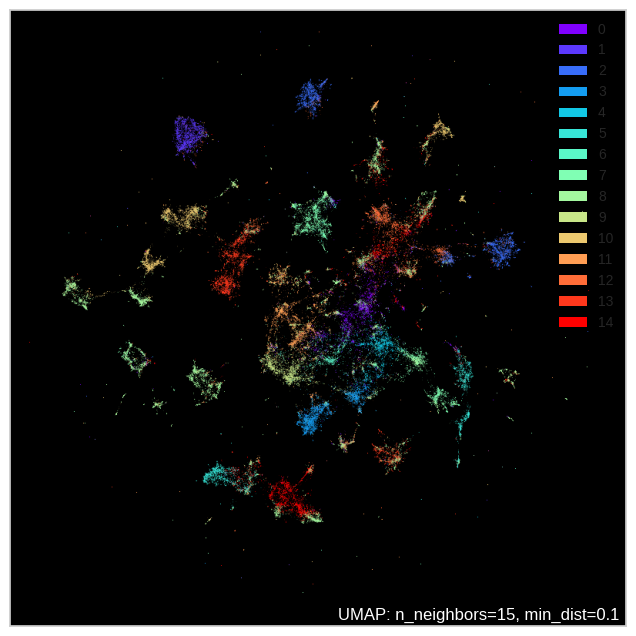

In [19]:
umap.plot.points(mapper_resnet, labels=labels_resnet, theme='fire')

In [20]:
class_img = {i: [] for i in range(len(km_resnet.cluster_centers_))}
for lab, embedding  in zip(labels_resnet, resnet_embeddings):
    class_img[lab].append(embedding)
    

In [21]:
projected_resnet = mapper_resnet.embedding_
projected_bert = mapper_bert.embedding_

In [22]:
print(bert_embeddings.shape)
resnet_embeddings.shape

(98458, 768)


(99900, 2048)

In [23]:
resnet_embeddings.shape

(99900, 2048)

# Study the disparsity of the semanthic between textual and Visual features

In [24]:
km_resnet

KMeans(max_iter=50, n_clusters=15, n_init=5, random_state=42)

In [25]:
km_bert

KMeans(max_iter=100, n_clusters=5, n_init=10, random_state=42)

In [168]:

def k_mean_distance(data, centroid, i_centroid, cluster_labels):
    distances = np.linalg.norm(data[cluster_labels == i_centroid] - centroid, axis=1)
    return np.mean(distances), distances

# Bert Cluster study
centroids = km_bert.cluster_centers_

c_mean_distances = []
std_distances = []
distribution_distances  = [[] for i in range(len(centroids))]
for i, centroid in enumerate(centroids):
    mean_distance, distances = k_mean_distance(bert_embeddings, centroid, i, labels_bert)
    c_mean_distances.append(mean_distance)
    std_distances.append(np.std(distances))
    distribution_distances[i] += list(distances)

[Text(1, 0, 'Mean 6.008790\n STD 1.136458'),
 Text(2, 0, 'Mean 5.986221\n STD 1.317257'),
 Text(3, 0, 'Mean 5.939733\n STD 1.611371'),
 Text(4, 0, 'Mean 5.519872\n STD 0.981055'),
 Text(5, 0, 'Mean 5.850821\n STD 0.982661')]

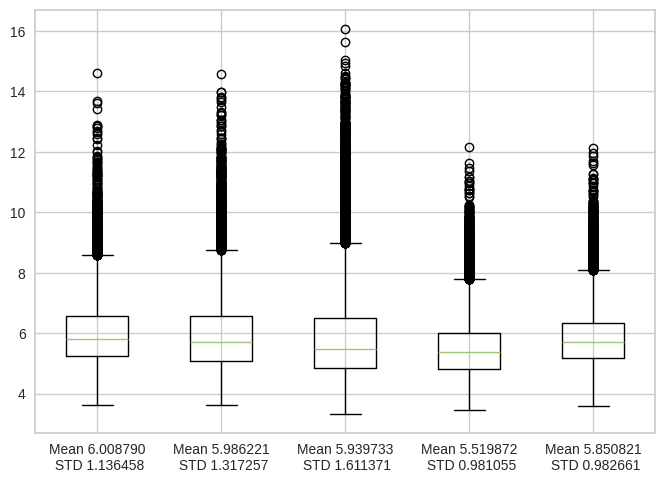

In [118]:
fig, ax = plt.subplots()
ax.boxplot(distribution_distances)
ax.set_xticklabels([f"Mean {c_mean_distances[i]:1f}\n STD {std_distances[i]:2f}" for i in range(len(centroids))])

In [47]:
caption_label = {}

label_embeddings = {i:[] for i in range(len(km_bert.cluster_centers_))}
caption_positive = {}
caption_negative = {}

for label, captions in class_caption.items():
    for cap in captions:
        caption_label[cap] = label
        
for label, captions in class_caption.items():
    for cap in captions:
        label_embeddings[label].append(contents[cap])
        
        
for caption, id_image, id_neg in triplets:
    caption_positive[caption] = id_image
    caption_negative[caption] = id_neg 
    
positive_caption = {j:i for i, j in caption_positive.items()}
 



In [170]:
# class_caption primary key with label
# contents primaty key caption with embedding
# triplets primary key (caption amb el id)

biased_captions = {}
possible_confusion_caption = {}


for i in tqdm.tqdm(range(len(triplets))[:1000]):
    caption = triplets[i][0]
    positive_id = triplets[i][1]
     
    caption_cluster_center = km_bert.cluster_centers_[caption_label[caption]]
    caption_embedding = contents[caption]
    cluster = caption_label[caption]
    
    
    
    #compute the distance to its cluster center 
    euclidean_distances = np.linalg.norm(caption_embedding - caption_cluster_center, axis=0)
    if euclidean_distances >= (c_mean_distances[cluster] + std_distances[cluster]*3):
        biased_captions[caption] = {}
        nearest_id = []
        
        distances_to_all_clusters = np.linalg.norm(caption_embedding - km_bert.cluster_centers_, axis=1)
        possible_confusion_cluster = np.argpartition(distances_to_all_clusters, 2)[1]
        
        
        ## get the embeddings of the true clust
        true_clust_emb = np.array(label_embeddings[cluster])
        
        # computing distance to all the embeddings:
        all_embeddings = np.array(list(contents.values()))
        
        # computing distances to that embeddings
        distances_points_conf_cluster = np.linalg.norm(caption_embedding - all_embeddings, axis=1)
        distances_own_clust = np.linalg.norm(caption_embedding - true_clust_emb, axis=1)
        
        # get the 20 NN from the two clusters (argpartition return the top 5 min indices)
        pos_error_indexes = np.argsort(distances_points_conf_cluster)[:10]
        pos_captions_errors = np.array(list(contents.keys()))[pos_error_indexes]
        
        # get the second nearest cluster
        clusters_of_possible_caption_errors = [caption_label[ii] for ii in pos_captions_errors]

        ## Saving the biased information
        biased_captions[caption]["nearest_captions"] = pos_captions_errors
        biased_captions[caption]["nearest_captions_clusters"] = clusters_of_possible_caption_errors
        biased_captions[caption]["nearest_embeddings_idx"] = pos_error_indexes
        biased_captions[caption]["nearest_second_cluster"] = possible_confusion_cluster
        
        for ps_cap in pos_captions_errors:
            nearest_id.append(caption_positive[ps_cap])
        
        biased_captions[caption]["nearest_images"] = nearest_id
        
        
        #top5_min_distances_new_clust = distances_points_conf_cluster[np.argpartition(distances_points_conf_cluster, 10)[:10]]
        #top5_min_distances_own_clust = distances_own_clust[np.argpartition(distances_own_clust, 5)[:5]]
        
        #print(top5_min_distances_new_clust)
        #print(top5_min_distances_own_clust)


100%|██████████| 1000/1000 [00:18<00:00, 55.25it/s]


In [171]:
captions_to_test = list(biased_captions.keys())

In [172]:
captions_to_test

['comparison photo of bathroom stretched in comical way',
 'Apartment building with fire escapes and red traffic light',
 'Produce boxes full of bananas, apples, and oranges. \n',
 'Partially eaten doughnut being help up in a persons hand. ',
 'Woman in glasses sits on edge of couch',
 'Toilet in corner with hole in tiled wall behind',
 'Multi colored kite flying on day with clear blue sky.',
 'Horse standing on sandy beach of open ocean.',
 'german shepherd catching frisbee in mouth with audience in background',
 'a white blue green and  yellow colored bus ',
 'Woman using immersion blender in large pot of liquid.',
 'Dog lying on rug in room with table. ',
 'The skier is competent enough to attempt the slope.',
 'an image of a man that is walking and carrying fruit ',
 'Tennis ball traveling towards Roger Federer holding racket',
 'Doorway view of a bathroom with rows of urinals.',
 'Horse pulling cart loaded with grasses with man guiding and dog walking nearby.']

In [173]:
example= biased_captions[captions_to_test[1]]
example

{'nearest_captions': array(['Apartment building with fire escapes and red traffic light',
        'Large, ornate building with clock tower taken from street level',
        'Pedestrian street sign with Apple label logo on building',
        'a city street with cars and busses near buildings',
        'a pole with both street lights and a stop sign ',
        'Street corner with stop sign with snow piles around',
        'STREET CORNER WITH STOP LIGHT, AND ROAD SIGNS',
        'A subway station with a subway coming up the West 4 track and people waiting on the platform.',
        'Red building with a clock and a window',
        'Traffic intersection with street signs surrounded by cars and trucks.'],
       dtype='<U250'),
 'nearest_captions_clusters': [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
 'nearest_embeddings_idx': array([  122, 24117, 59987, 56817, 25567, 18739, 44750, 18587, 42700,
        60152]),
 'nearest_second_cluster': 2,
 'nearest_images': [12416,
  183151,
  150385,
  403590,
  52

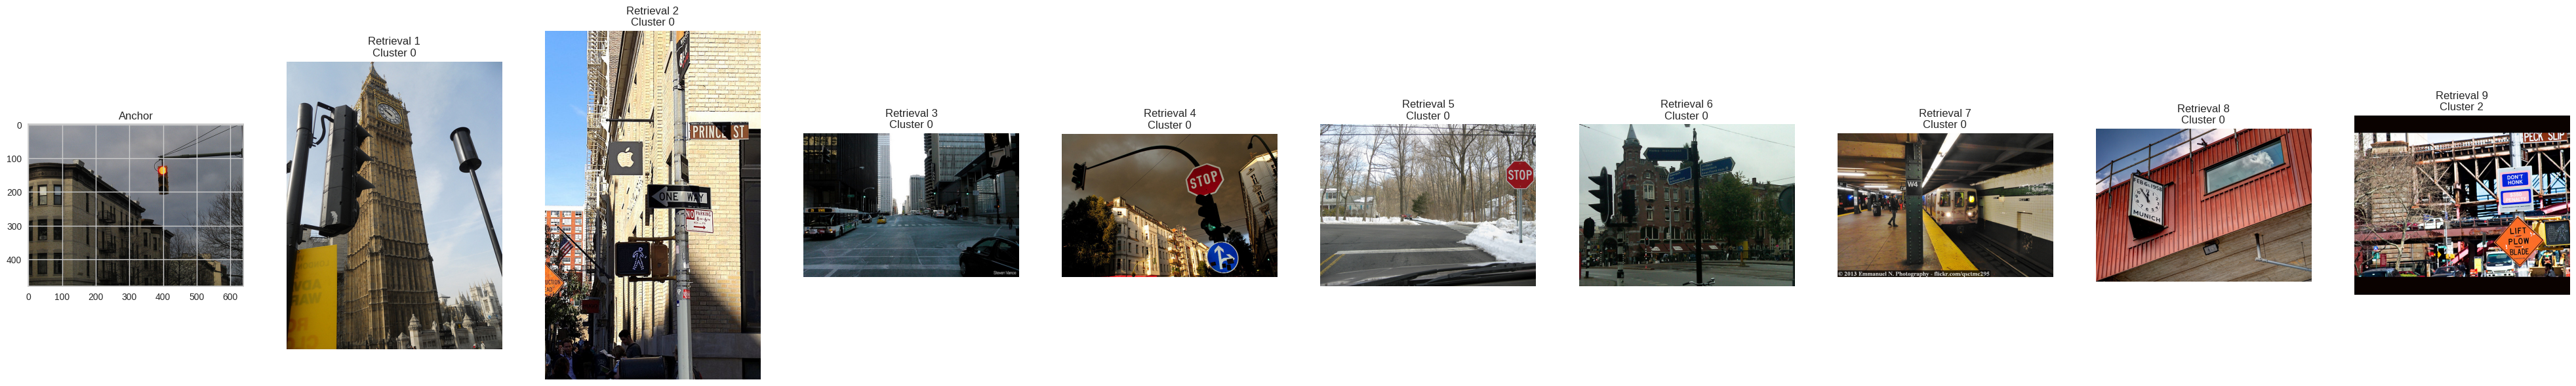

In [174]:
# Load and display the anchor image
nearest_images = example["nearest_images"]
nearest_captions_clusters = example["nearest_captions_clusters"]

anchor_image = load_image(nearest_images[0], root_path=TRAIN_PATH)

# Load and display the retrieval images
retrieval_images = [load_image(image_path, root_path=TRAIN_PATH) for image_path in nearest_images[1:]]
retrieval_clusters = nearest_captions_clusters[1:]

# Plotting
fig, axes = plt.subplots(1, len(retrieval_images) + 1, figsize=(50, 25))

# Plot anchor image
axes[0].imshow(anchor_image)
axes[0].set_title('Anchor')

# Plot retrieval images
for i, (image, cluster) in enumerate(zip(retrieval_images, retrieval_clusters), 1):
    axes[i].imshow(image)
    axes[i].set_title(f'Retrieval {i}\nCluster {cluster}')
    axes[i].axis('off')

#plt.tight_layout()
plt.show()

### Extracting the closest images from the first image. 

In [73]:
def k_mean_distance(data, centroid, i_centroid, cluster_labels):
    distances = np.linalg.norm(data[cluster_labels == i_centroid] - centroid, axis=1)
    return np.mean(distances), distances

# Bert Cluster study
centroids = km_resnet.cluster_centers_

c_mean_distances = []
std_distances = []
distribution_distances  = [[] for i in range(len(centroids))]
for i, centroid in enumerate(centroids):
    mean_distance, distances = k_mean_distance(resnet_embeddings, centroid, i, labels_resnet)
    c_mean_distances.append(mean_distance)
    std_distances.append(np.std(distances))
    distribution_distances[i] += list(distances)

[Text(1, 0, 'M 17.991776\n STD 3.110159'),
 Text(2, 0, 'M 8.616897\n STD 3.216453'),
 Text(3, 0, 'M 9.755786\n STD 2.667947'),
 Text(4, 0, 'M 11.271340\n STD 2.610086'),
 Text(5, 0, 'M 18.178133\n STD 3.299928'),
 Text(6, 0, 'M 9.773330\n STD 2.308588'),
 Text(7, 0, 'M 19.824984\n STD 3.212477'),
 Text(8, 0, 'M 12.344062\n STD 2.365634'),
 Text(9, 0, 'M 10.717285\n STD 2.350708'),
 Text(10, 0, 'M 13.082130\n STD 2.701104'),
 Text(11, 0, 'M 13.396309\n STD 3.248625'),
 Text(12, 0, 'M 15.623322\n STD 2.926726'),
 Text(13, 0, 'M 18.276161\n STD 3.261188'),
 Text(14, 0, 'M 13.432384\n STD 2.723244'),
 Text(15, 0, 'M 14.724160\n STD 2.807409')]

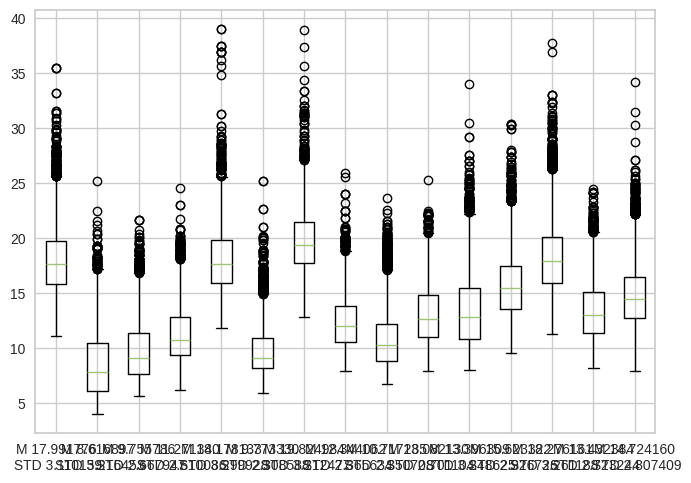

In [76]:
fig, ax = plt.subplots()
ax.boxplot(distribution_distances)
ax.set_xticklabels([f"M {c_mean_distances[i]:1f}\n STD {std_distances[i]:2f}" for i in range(len(centroids))])

In [88]:
@torch.no_grad
def extract_embedding_resnet(id, root_path):
    model = resnet152(weights=ResNet152_Weights.DEFAULT)
    modules=list(model.children())[:-1]
    model=nn.Sequential(*modules).to(DEVICE)
    model.eval()
    
    image = load_image(id, root_path=root_path)
    image = functional.normalize(functional.to_tensor(image), mean=(0.485, 0.456, 0.406),
                                            std=(0.229, 0.224, 0.225)).to(DEVICE)
    
    image = functional.resize(img=image, size=(224,224))
    features = model(image.unsqueeze(0)).view(-1, 2048) 
    return features.cpu().numpy()

In [178]:
for i in range(len(triplets)):
    
    if triplets[i][1] == 12416 and triplets[i][0] == "Apartment building with fire escapes and red traffic light" :
        print(i)
        
anchor_embedding = resnet_embeddings[122]# extract_embedding_resnet(150385, root_path= TRAIN_PATH)

122


In [179]:
distances_to_all_images_embeddings = np.linalg.norm(anchor_embedding - resnet_embeddings  , axis=1)
pos_error_indexes_images = np.argsort(distances_to_all_images_embeddings)[:15]
print(pos_error_indexes_images)

iii = np.array(list(triplets))[pos_error_indexes_images]

print(iii)

nearest_images = np.unique([int(t[1]) for t in iii])


[89587   122 37297 30082 37834 30045 55303 86678 37559  8889 91058 22485
  2847 12010 37189]
[['Dark clouds gloom over a red light and 4 large apartment buildings. '
  '12416' '88920']
 ['Apartment building with fire escapes and red traffic light' '12416'
  '243986']
 ['A group of traffic lights hanging along side of a tall building.'
  '46883' '445592']
 ['The architecture of old buildings behind a red traffic light' '10222'
  '43854']
 ['A city traffic light near a big building.' '505965' '323558']
 ['Outside view of tall brown building and red traffic light signal.'
  '505965' '68609']
 ['a white and green street sign and a traffic light' '268855' '116617']
 ['a street sign above a red traffic light' '268855' '443082']
 ['A stop light that is flashing green in front of a group of people.'
  '131674' '372868']
 ["A traffic signal indicating it's time to get a move on." '440625'
  '47617']
 ['A traffic light and a building on a street.' '311424' '560409']
 ['A traffic signal is on the

In [159]:
print(distances_to_all_images_embeddings[[58894 ,84095, 75996, 60679, 40082]])

[9.457507 9.396611 9.457507 0.       9.541256]


In [180]:
batch_embeddings = None

for im in nearest_images:
    f = extract_embedding_resnet(int(im), root_path=TRAIN_PATH)
    if batch_embeddings is None:
        batch_embeddings = f
    else:
        batch_embeddings = np.concatenate((batch_embeddings, f), axis=0)
        
print(batch_embeddings.shape)

(10, 2048)


In [181]:
labels_pred = km_resnet.predict(batch_embeddings)

In [182]:
labels_pred

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [183]:
print(nearest_images)
print(anchor_image)

[ 10222  12416  46883 131674 268855 311424 440625 466294 477417 505965]
<PIL.Image.Image image mode=RGB size=640x480 at 0x7F589306D2B0>


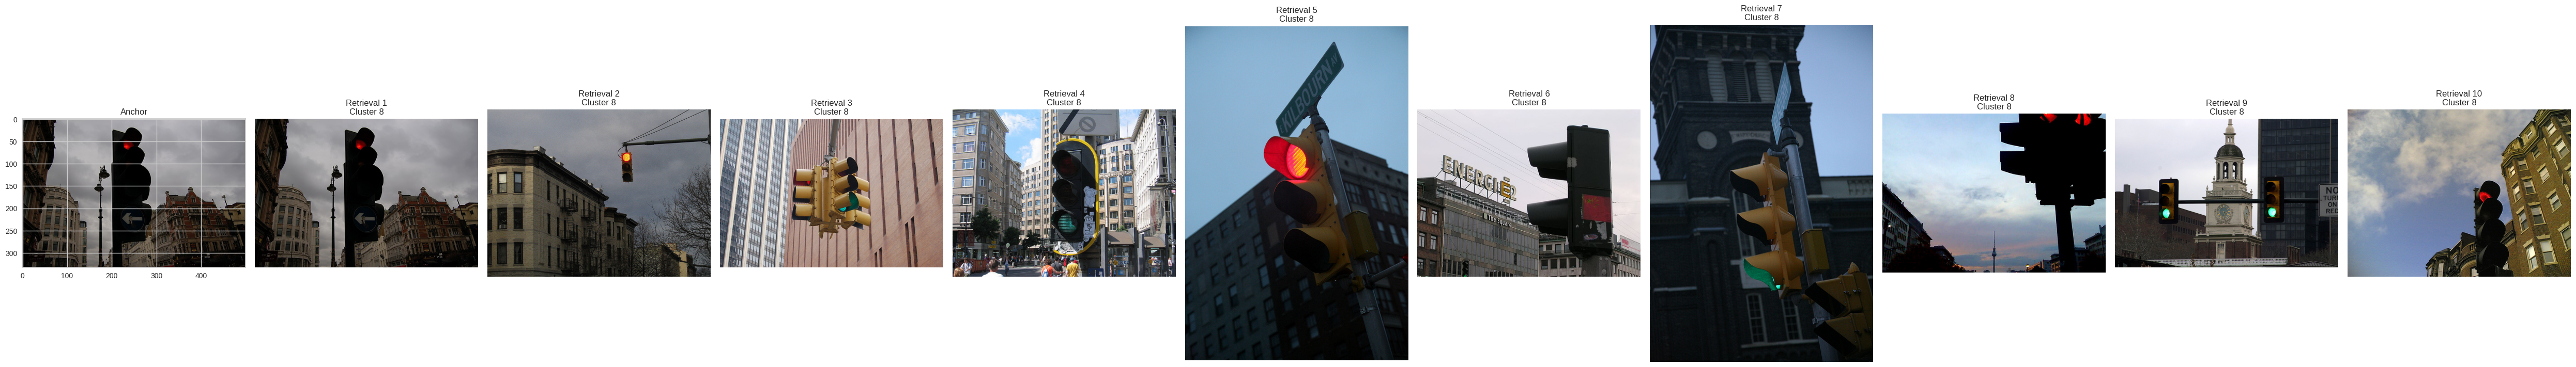

In [185]:
# Load and display the anchor image
#nearest_images = [int(t[1]) for t in iii]
nearest_captions_clusters = labels_pred
anchor_image = load_image(int(nearest_images[0]), root_path=TRAIN_PATH)

# Load and display the retrieval images
retrieval_images = [load_image(int(image_path), root_path=TRAIN_PATH) for image_path in nearest_images]
retrieval_clusters = nearest_captions_clusters

# Plotting
fig, axes = plt.subplots(1, len(retrieval_images) +1, figsize=(50, 25))

# Plot anchor image
axes[0].imshow(anchor_image)
axes[0].set_title('Anchor')

# Plot retrieval images
for i, (image, cluster) in enumerate(zip(retrieval_images, retrieval_clusters), 1):
    axes[i].imshow(image)
    axes[i].set_title(f'Retrieval {i}\nCluster {cluster}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [79]:
distances_to_all_images_embeddings


array([21.103352, 17.556917, 14.676547, ..., 16.303467, 15.25871 ,
       18.667675], dtype=float32)